In [1]:
# Third Party Imports
import pandas as pd
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import bat
from bat import log_to_dataframe
from bat import dataframe_to_matrix

In [35]:
bro_df = log_to_dataframe.LogToDataFrame('/home/dane/giant/dns.log')
#bro_df.head()

Successfully monitoring /home/dane/giant/dns.log...


In [36]:
# Using Pandas we can easily and efficiently compute additional data metrics
# Here we use the vectorized operations of Pandas/Numpy to compute query length
bro_df['query_length'] = bro_df['query'].str.len()

In [37]:
#http://www.networksorcery.com/enp/protocol/dns.htm
#features = ['id.orig_h','id.orig_p','id.resp_h','AA', 'RA', 'RD', 'TC', 'Z', 'rejected', 'proto', 'query', 
#            'qclass_name', 'qtype_name', 'rcode_name', 'query_length']
features = ['id.orig_h','id.orig_p',
            'id.resp_h', 'id.resp_p',
            'rejected','proto',
            'rcode_name', 'query_length']
feature_df = bro_df[features]
#feature_df.head()


In [38]:
to_matrix = dataframe_to_matrix.DataFrameToMatrix()
bro_matrix = to_matrix.fit_transform(feature_df)

Changing column id.orig_h to category...
Changing column id.resp_h to category...
Changing column proto to category...
Changing column rcode_name to category...
Normalizing column id.orig_p...
Normalizing column id.resp_p...
Normalizing column query_length...


In [39]:
# Just showing that the class is tracking categoricals and normalization maps
print(to_matrix.cat_columns)
print(to_matrix.norm_map)

['id.orig_h', 'id.resp_h', 'proto', 'rcode_name']
{'id.orig_p': (137, 64896), 'id.resp_p': (53, 5355), 'query_length': (1, 54)}


In [41]:
# Now we're ready for scikit-learn!
# Just some simple stuff for this example, KMeans and TSNE projection
kmeans = KMeans(n_clusters=3).fit_predict(bro_matrix)
#projection = TSNE().fit_transform(bro_matrix)

# Now we can put our ML results back onto our dataframe!
#bro_df['x'] = projection[:, 0] # Projection X Column
#bro_df['y'] = projection[:, 1] # Projection Y Column
bro_df['cluster'] = kmeans
#bro_df[['id.orig_h','id.orig_p','id.resp_h','query', 'proto', 'x', 'y', 'cluster']].head()  # Showing the scikit-learn results in our dataframe
#bro_df[['id.orig_h','id.orig_p','id.resp_h','query', 'proto',  'cluster']].head()  # Showing the scikit-learn results in our dataframe
bro_df[['id.orig_h','id.orig_p',
            'id.resp_h', 'id.resp_p',
            'rejected','proto',
            'rcode_name', 'query_length',
        'cluster']].head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,rejected,proto,rcode_name,query_length,cluster
ts,,,,,,,,,
2018-12-07 20:58:54.398597,192.168.230.10,5353,224.0.0.251,5353,False,udp,NOERROR,54,0
2018-12-07 20:58:54.398597,fe80::fe66:9c07:d4c0:e690,5353,ff02::fb,5353,False,udp,-,54,1
2018-12-07 20:58:54.398597,fe80::8a51:fbff:fee9:e904,5353,ff02::fb,5353,False,udp,NOERROR,54,0
2018-12-07 21:00:00.098604,192.168.230.115,45541,192.168.196.52,53,False,udp,NXDOMAIN,1,2
2018-12-07 20:58:54.395193,fe80::fe66:9c07:d4c0:e690,5353,ff02::fb,5353,False,udp,-,54,1


In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 8.0
plt.rcParams['figure.figsize'] = 15.0, 7.0

In [43]:
#print(bro_df)
cluster_groups = bro_df.groupby('cluster')

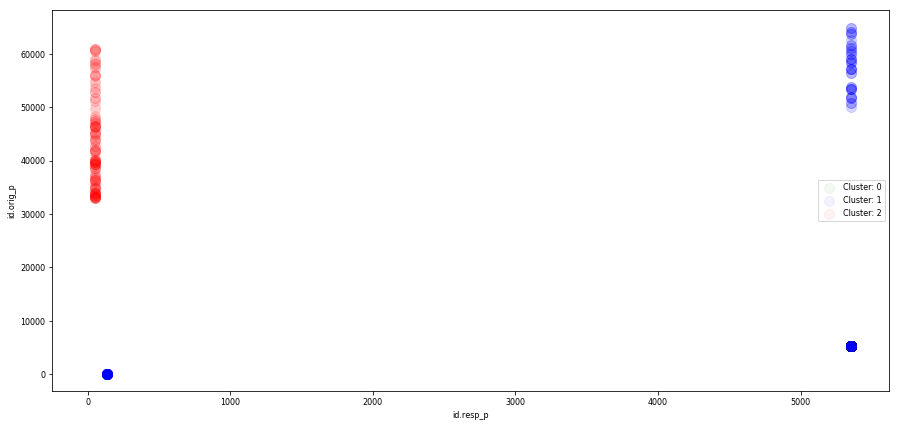

In [53]:
# Now use dataframe group by cluster
#cluster_groups = bro_df.groupby('cluster')

'''bro_df[['id.orig_h','id.orig_p',
            'id.resp_h', 'id.resp_p',
            'rejected','proto',
            'rcode_name', 'query_length',
        'cluster']].head()
'''
# Plot the Machine Learning results
fig, ax = plt.subplots()
colors = {0:'green', 1:'blue', 2:'red'}#, 3:'orange', 4:'purple'}#, 5:'black', 6:'grey', 7:'pink'}
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='id.resp_p', y='id.orig_p', alpha=0.05, s=100,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [26]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
#show_fields = ['id.orig_h','id.orig_p','id.resp_h','query', 'proto', 'x', 'y', 'cluster', 'Z']
show_fields = ['id.orig_h','id.orig_p',
               'id.resp_h', 'rejected', 
               'rcode_name', 'query_length']
#show_fields = ['id.orig_h','id.orig_p','id.resp_h','AA', 'RA', 'RD', 'TC', 'rejected', 'proto', 'query', 
#            'qclass_name', 'qtype_name', 'rcode_name', 'query_length']
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    #print(group[show_fields])
    print(group[show_fields].head())


Cluster 0: 444 observations
                                            id.orig_h  id.orig_p    id.resp_h  rejected rcode_name  query_length
ts                                                                                                              
2018-12-07 20:58:54.398597             192.168.230.10       5353  224.0.0.251     False    NOERROR            54
2018-12-07 20:58:54.398597  fe80::8a51:fbff:fee9:e904       5353     ff02::fb     False    NOERROR            54
2018-12-07 20:58:54.395193  fe80::8a51:fbff:fee9:e904       5353     ff02::fb     False    NOERROR            54
2018-12-07 20:58:54.394030             192.168.230.10       5353  224.0.0.251     False    NOERROR            54
2018-12-07 21:00:54.406018  fe80::8a51:fbff:fee9:e904       5353     ff02::fb     False    NOERROR            54

Cluster 1: 247 observations
                                  id.orig_h  id.orig_p       id.resp_h  rejected rcode_name  query_length
ts                                           